In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import sys
import time
import tqdm

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import pickle

import io
import string
import re
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.util import ngrams
from nltk import word_tokenize

import fasttext

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
df = pd.read_csv("/mnt/d/work2/turkish-news-classification/data/cleaned.csv", usecols=["Haber Gövdesi Cleaned", "Sınıf"])
df = df.dropna()
df = df.reset_index(drop=True)

In [6]:
X = df["Haber Gövdesi Cleaned"]
y = df["Sınıf"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [9]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=y)

In [10]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
train_df["label_format"] = 0
for i in range(len(train_df)):
    train_df.label_format[i] = "__label__" + str(train_df["Sınıf"][i]) + " " + str(train_df["Haber Gövdesi Cleaned"][i])

/tmp/ipykernel_1353/3307756861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.label_format[i] = "__label__" + str(train_df["Sınıf"][i]) + " " + str(train_df["Haber Gövdesi Cleaned"][i])


In [12]:
test_df["label_format"] = 0
for i in range(len(test_df)):
    test_df.label_format[i] = "__label__" + str(test_df["Sınıf"][i]) + " " + str(test_df["Haber Gövdesi Cleaned"][i])

/tmp/ipykernel_1353/271246589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.label_format[i] = "__label__" + str(test_df["Sınıf"][i]) + " " + str(test_df["Haber Gövdesi Cleaned"][i])


In [13]:
train_df.label_format.to_csv("fasttext_train.txt", index=None, header=None)
test_df.label_format.to_csv("fasttext_test.txt", index=None, header=None)

In [14]:
model5_train_start = time.time()
fasttext_model = fasttext.train_supervised("fasttext_train.txt", epoch=50, lr=0.05, label_prefix="__label__", dim=300)
model5_train_time = time.time() - model5_train_start
print(f"FastText Train Time = {model5_train_time:.4f}")

Read 146M words
Number of words:  1444598
Number of labels: 9
Progress: 100.0% words/sec/thread:  827302 lr:  0.000008 avg.loss:  0.067101 ETA:   0h 0m 0s

FastText Train Time = 832.7822


Progress: 100.0% words/sec/thread:  827226 lr:  0.000000 avg.loss:  0.067093 ETA:   0h 0m 0s


In [55]:
def predict_fasttext(row):
    pred = fasttext_model.predict([row])[0][0][0].replace('__label__', '')
    return dict(zip(le.classes_, le.transform(le.classes_)))[pred]

In [57]:
model5_test_start = time.time()
fasttext_pred_test = [predict_fasttext(test) for test in X_test]
model5_test_time = time.time() - model5_test_start
print(f"FastText Test Time = {model5_test_time:.4f}")

FastText Test Time = 9.7947


In [59]:
fasttext_pred_train = [predict_fasttext(train) for train in X_train]
fasttext_train_score = accuracy_score(fasttext_pred_train, y_train)
fasttext_test_score = accuracy_score(fasttext_pred_test, y_test)
print(f"FastText Train Score = {fasttext_train_score * 100:.4f}%")
print(f"FastText Test Score = {fasttext_test_score * 100:.4f}%")

FastText Train Score = 99.8886%
FastText Test Score = 92.0431%


In [60]:
fasttext_precision_score = precision_score(y_test, fasttext_pred_test, average="weighted")
fasttext_f1_score = f1_score(y_test, fasttext_pred_test, average="weighted")
fasttext_recall_score = recall_score(y_test, fasttext_pred_test, average="weighted")
fasttext_accuracy_score = accuracy_score(y_test, fasttext_pred_test)

print(f"FastText Precision Score = {fasttext_precision_score * 100:.4f}%")
print(f"FastText F1 Score = {fasttext_f1_score * 100:.4f}%")
print(f"FastText Recall Score = {fasttext_recall_score * 100:.4f}%")
print(f"FastText Accuracy Score = {fasttext_accuracy_score * 100:.4f}%")

FastText Precision Score = 92.0186%
FastText F1 Score = 92.0259%
FastText Recall Score = 92.0431%
FastText Accuracy Score = 92.0431%


In [61]:
print(classification_report(y_test, fasttext_pred_test, target_names=le.classes_))

                 precision    recall  f1-score   support

Bilim-Teknoloji       0.86      0.85      0.86      3051
 Finans-Ekonomi       0.85      0.83      0.84      3668
   Kültür-Sanat       0.77      0.79      0.78      4663
        Magazin       0.95      0.95      0.95     31592
         Sağlık       0.92      0.94      0.93      4786
        Siyaset       0.92      0.92      0.92     14726
           Spor       0.97      0.97      0.97     13144
         Turizm       0.83      0.82      0.83      2966
          Çevre       0.74      0.68      0.71      1561

       accuracy                           0.92     80157
      macro avg       0.87      0.86      0.87     80157
   weighted avg       0.92      0.92      0.92     80157



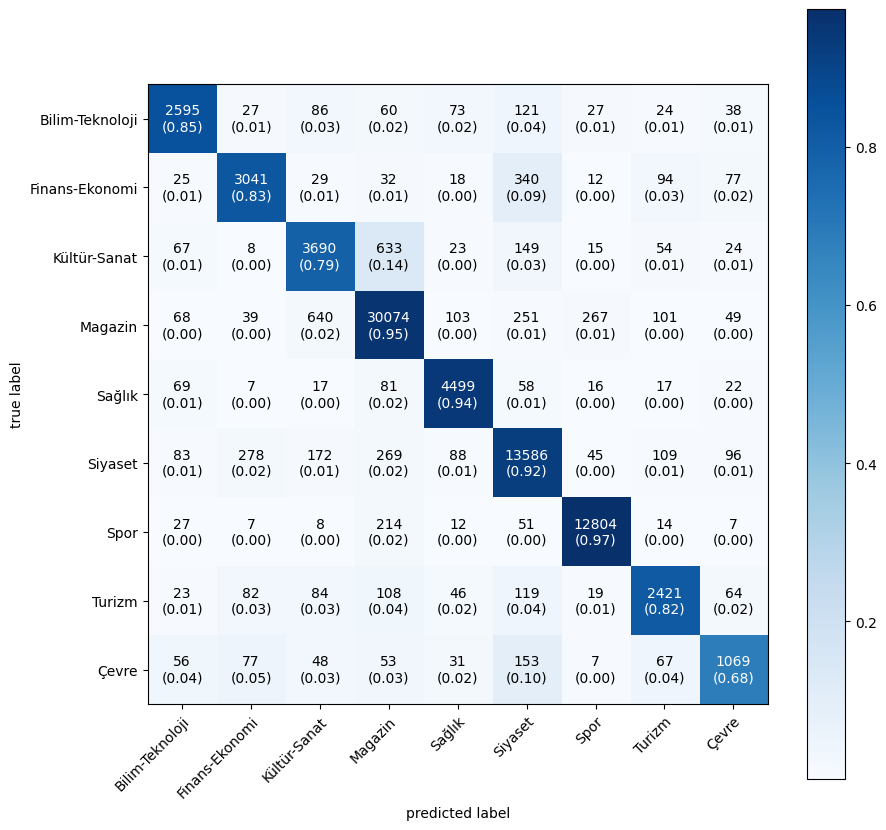

In [62]:
simplernn_cm = confusion_matrix(y_test, fasttext_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_, figsize=(10, 10))
plt.savefig("./output/fasttext.png")
plt.show()